# Advection-diffusion 1D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

$\partial_t u = \partial_{xx}u - \beta u_x$

## Libraries

In [743]:
import sys
sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')

In [744]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Utils

In [745]:
def Kphiphi_assembly(Xomega, Xboundary , h, b, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K(kernel, Xomega, Xomega, k_param) # K(X,X)
  val2 = K_dot(kernel, Xomega, Xomega, k_param, 0) # D1 K(X,X)
  val3 = val2 # D2 K(X,X)
  val4 = K_ddot(kernel, Xomega, Xomega, k_param, 0, 0) # D1D1 K(X,X)
  val5 = val4 # D2D2 K(X,X)
  val6 = K_ddot(kernel, Xomega, Xomega, k_param, 0, 1) # D2D1 K(X,X)
  val7 = K_dddot(kernel, Xomega, Xomega, k_param, 0, 1, 1) # D2D2 D1 K(X,X)
  val8 = K_dddot(kernel, Xomega, Xomega, k_param, 0, 0, 1) # D2 D1D1 K(X,X)
  val9 = K_ddddot(kernel, Xomega, Xomega, k_param, 0, 0, 1, 1) # D2D2 D1D1 K(X,X)
  val = val1-h*val4+b*h*val2-h*(val5-h*val9+b*h*val7)+b*h*(val3-h*val8+b*h*val6)
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = K(kernel, Xomega, Xboundary, k_param)
  val4 = K_ddot(kernel, Xomega, Xboundary, k_param, 0, 0)
  val2 = K_dot(kernel, Xomega, Xboundary, k_param, 0)
  val = val1-h*val4+b*h*val2
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K(kernel, Xboundary , Xboundary, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [746]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, b, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K(kernel, Xomega, Xtest, k_param)
  val4 = K_ddot(kernel, Xomega, Xtest, k_param, 0, 0)
  val2 = K_dot(kernel, Xomega, Xtest, k_param, 0)
  val = val1-h*val4+b*h*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = K(kernel, Xboundary , Xtest, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

## How far can we go ?

In [747]:
# X_full
Xfull = np.linspace(0,1,502)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
u0 = ad_u0(Xomega)
# Advection coefficient
beta = 5
# Kernel lenght-scale
k_param = 0.5
# Time step
h = 0.01

Build `Kphiphi`

In [748]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, k = 'Gaussian', k_param = k_param)

Build `y_prev`

In [749]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [750]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)

Get `K(Xtest,Xfull)`

In [751]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, k = 'Gaussian', k_param = k_param)

In [752]:
u_next = np.dot(Kphi.T,sol)

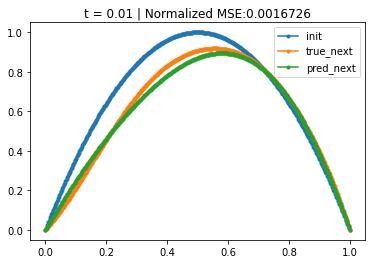

In [753]:
# Initial condition
plt.plot(Xfull,ad_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,ad_sol(Xfull,h,beta,5),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,ad_sol(Xfull,h,beta,5))/mean_squared_error(0*ad_sol(Xfull,h,beta,5),ad_sol(Xfull,h,beta,5))
plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
plt.legend()
plt.show()

## Let's take small steps 

Say we want to get to `t=0.2` by taking `h = 0.01`

In [754]:
t = 0.1
steps = int(t//h)
# Initialize at the initial condition
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
    u_next = np.dot(Kphi.T,sol)
    # update
    uprev = u_next[1:-1]

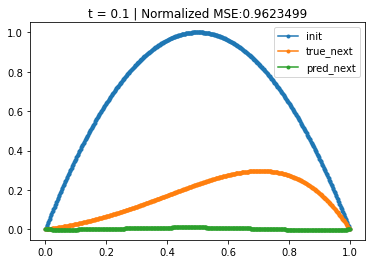

In [755]:
# Initial condition
plt.plot(Xfull,ad_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,ad_sol(Xfull,t,beta,5),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,ad_sol(Xfull,t,beta,5))/mean_squared_error(0*ad_sol(Xfull,t,beta,5),ad_sol(Xfull,t,beta,5))
plt.title('t = {} | Normalized MSE:{}'.format(t, round(nmse,7)))
plt.legend()
plt.show()

In [756]:
# Study converge as we increase resolution of points. 
# Try Matern kernels, to see if we can get rid of regularization.
# Add advection term. 